# Day 1 Class 3 Code 

Start by opening a terminal window, navigating to the GitHub directory, and running the commands:

```
python3 -m venv ~/.venvs/stat41130
source ~/.venvs/stat41130/bin/activate
python -m pip install -U pip
pip install -r requirements_ECMWF.txt  
```

Then when you click run on the boxes above make sure you choose the version of Python in the directory above /.venvs/stat41130

Note: this is only for Linux systems. Get an LLM to translate it into Windows commands

In [1]:
import sys
print(sys.version)
try:
    import numpy, matplotlib, torch  # noqa: F401
    print("✅ numpy/matplotlib/torch found")
except Exception as e:
    print("⚠️ Missing package:", e)

3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
✅ numpy/matplotlib/torch found


## Day 1 Companion Script (Lectures: Linear Regression → Neural Networks, forward-pass focus)

This script is a heavily commented, line-by-line teaching companion for the first two lectures.
It takes you through:
* dot products and linear transforms,
* to linear regression as a single-neuron network,
* to activations (sigmoid, tanh, ReLU),
* to multi-feature inputs and matrix shapes,
* and finally to a small taste of PyTorch and autograd.

How to use:
- Run this script top-to-bottom. Skim comments first, then re-run slowly, line-by-line.
- Search for the tag 'EXERCISE' — those blocks are designed to pause & discuss.
- You can tweak knobs (learning rate, epochs, initial weights) and see the effect.
- Plots are optional but nice; they use matplotlib (no custom styles set, per course rules).


Note:
    We intentionally do not use PyTorch until Section 10 to ensure you understand the core math.
    Early sections use only Python and NumPy.


## Section 0 — Imports, printing helpers, reproducibility

You can ignore most of this part. It just tidies up the output. Click the run button on the left and skip over it

In [2]:
from __future__ import annotations

import sys
import math
import random
from dataclasses import dataclass
from typing import Tuple, Callable, Iterable, List, Optional

import numpy as np

# Matplotlib is used for a few simple 1-figure plots (one chart per figure; no custom colors).
import matplotlib.pyplot as plt

# We will only import torch later (Section 10) so that the early parts are framework-free.

# For reproducibility in random demos:
np.random.seed(42)
random.seed(42)


def header(title: str):
    """Pretty-print a section header so it's obvious in the console."""
    line = "=" * len(title)
    print(f"\n{line}\n{title}\n{line}\n")


def subheader(title: str):
    """Pretty-print a sub-section header."""
    line = "-" * len(title)
    print(f"\n{title}\n{line}")


def show_vector(name: str, v: np.ndarray):
    """Display a 1-D vector with its shape (convenience for teaching)."""
    print(f"{name} (shape {v.shape}): {np.array2string(v, precision=4, floatmode='fixed')}")


def show_matrix(name: str, M: np.ndarray):
    """Display a 2-D matrix with its shape (convenience for teaching)."""
    with np.printoptions(precision=4, suppress=True, floatmode='fixed'):
        print(f"{name} (shape {M.shape}):\n{M}")

## Section 1 — The tiniest 'weather' dataset & dot product warm‑up

We'll reuse the 5-point temperature example from the lecture slides:
X = temperature yesterday, y = temperature today

In [3]:
X = np.array([16.09, 15.56, 15.85, 15.69, 15.01], dtype=float)
y = np.array([17.62, 14.88, 16.32, 16.28, 14.96], dtype=float)

show_vector("X (yesterday °C)", X)
show_vector("y (today °C)", y)

# Dot product refresher (forward step inside a neuron):
x = np.array([2.0, -3.0, 0.5])  # toy 3-d input
w = np.array([0.1, 0.2, 0.3])   # toy weights
b = 0.05                        # bias

dot = x @ w  # same as np.dot(x, w)
z = dot + b  # pre-activation (a.k.a. linear transform)
print(f"\nToy dot product: x @ w = {dot:.4f}, plus bias => z = {z:.4f}")

# EXERCISE (verbal): Change x, w, b and predict how z changes before running the code.

X (yesterday °C) (shape (5,)): [16.0900 15.5600 15.8500 15.6900 15.0100]
y (today °C) (shape (5,)): [17.6200 14.8800 16.3200 16.2800 14.9600]

Toy dot product: x @ w = -0.2500, plus bias => z = -0.2000


## Section 2 — Linear regression as a single-neuron network

In [4]:
# A linear regression with 1 feature can be seen as:
# y_hat = w * X + b  where w,b are parameters to learn.

def predict_lr_1d(X: np.ndarray, w: float, b: float) -> np.ndarray:
    """Forward pass for 1D linear regression."""
    return w * X + b


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Root Mean Squared Error — often interpretable in the same units as y."""
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


# Let's try the two candidates from the slides to build intuition.
candidates = [
    dict(w=0.0, b=0.5),
    dict(w=1.0, b=1.0),
]

for c in candidates:
    yhat = predict_lr_1d(X, c["w"], c["b"])
    loss = rmse(y, yhat)
    print(f"Candidate (w={c['w']:.2f}, b={c['b']:.2f}) → RMSE = {loss:.4f}")

# The second pair should be dramatically better on these 5 points (as shown in class).

Candidate (w=0.00, b=0.50) → RMSE = 15.5451
Candidate (w=1.00, b=1.00) → RMSE = 0.9649


## Section 3 — Visual intuition: plotting the fit for a few (w, b)

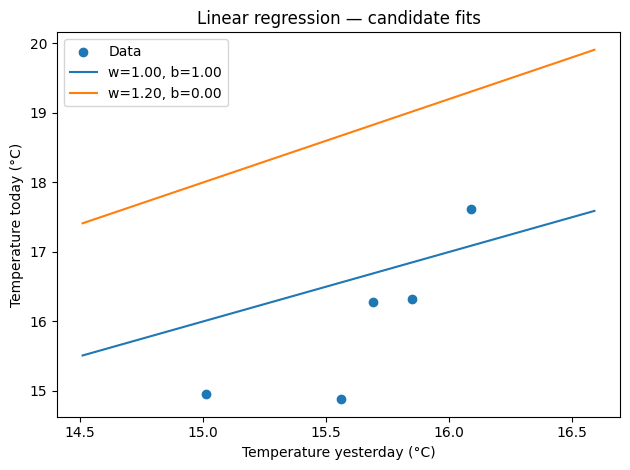

In [5]:
def plot_candidates(X: np.ndarray, y: np.ndarray, wb_list: List[Tuple[float, float]]):
    """
    Show X vs y and a few candidate regression lines.
    Rule for plots in this course:
        * matplotlib only
        * one chart per figure
        * do not set any specific colors or styles
    """
    plt.figure()
    plt.scatter(X, y, label="Data")
    xgrid = np.linspace(X.min()-0.5, X.max()+0.5, 100)
    for w, b in wb_list:
        plt.plot(xgrid, w * xgrid + b, label=f"w={w:.2f}, b={b:.2f}")
    plt.xlabel("Temperature yesterday (°C)")
    plt.ylabel("Temperature today (°C)")
    plt.title("Linear regression — candidate fits")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_candidates(X, y, wb_list=[(1.0, 1.0), (1.2, 0.0)])

**Figure: Linear regression — candidate fits**  

- The points show the observed relationship (Temperature yesterday (°C) vs Temperature today (°C)).
- Each line is a *candidate* linear model with specific parameters *(w, b)*.
- Where a line passes close to many points, its error (e.g., RMSE) is lower.
- Play around with the values of the slope (w) and intercept (b) to see which values improve the fit.

## Section 4 — Loss landscapes by brute force (grid search)

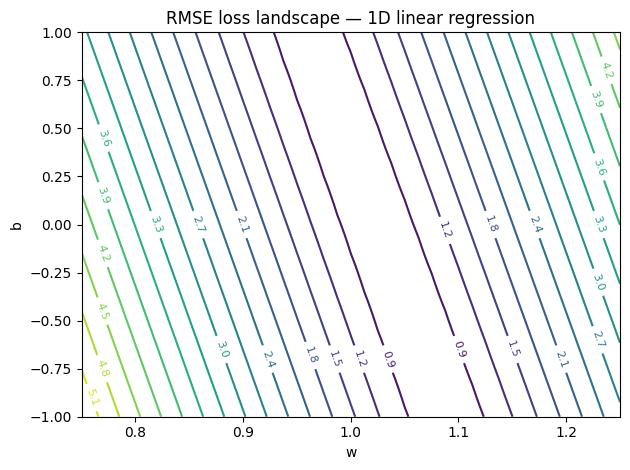

In [6]:
def grid_search_rmse(X: np.ndarray, y: np.ndarray,
                     w_values: np.ndarray, b_values: np.ndarray) -> np.ndarray:
    """Return a 2D array L[i,j] = RMSE at w[i], b[j]."""
    L = np.zeros((len(w_values), len(b_values)), dtype=float)
    for i, w in enumerate(w_values):
        for j, b in enumerate(b_values):
            L[i, j] = rmse(y, predict_lr_1d(X, w, b))
    return L


w_grid = np.linspace(0.75, 1.25, 41)  # 41 points in [0, 2]
b_grid = np.linspace(-1.0, 1.0, 41)
L = grid_search_rmse(X, y, w_grid, b_grid)

# Visualize as a contour plot (one figure, no custom colors).
plt.figure()
W, B = np.meshgrid(w_grid, b_grid, indexing="ij")
CS = plt.contour(W, B, L, levels=15)
plt.clabel(CS, inline=True, fontsize=8)
plt.xlabel("w")
plt.ylabel("b")
plt.title("RMSE loss landscape — 1D linear regression")
plt.tight_layout()
plt.show()

**Figure: RMSE loss landscape — 1D linear regression**  

- Axes are model parameters *(w, b)*; contours connect points with equal loss (e.g., RMSE).
- The darker/inner contours indicate lower loss—i.e., better fits.
- Gradient-based methods move across this surface toward the minimum.
- The shape (curvature) hints at how sensitive the loss is to each parameter.

## Section 5 — Gradient descent for 1D linear regression (by hand)

Epoch    0 | RMSE: 0.945800 | w: 0.998072 | b: 0.999874
Epoch   12 | RMSE: 0.808423 | w: 0.981143 | b: 0.998764
Epoch   24 | RMSE: 0.762661 | w: 0.971897 | b: 0.998145
Epoch   36 | RMSE: 0.748466 | w: 0.966848 | b: 0.997794
Epoch   48 | RMSE: 0.744178 | w: 0.964091 | b: 0.997589
Epoch   60 | RMSE: 0.742894 | w: 0.962586 | b: 0.997464
Epoch   72 | RMSE: 0.742510 | w: 0.961764 | b: 0.997383
Epoch   84 | RMSE: 0.742395 | w: 0.961317 | b: 0.997326
Epoch   96 | RMSE: 0.742360 | w: 0.961073 | b: 0.997282
Epoch  108 | RMSE: 0.742350 | w: 0.960941 | b: 0.997245


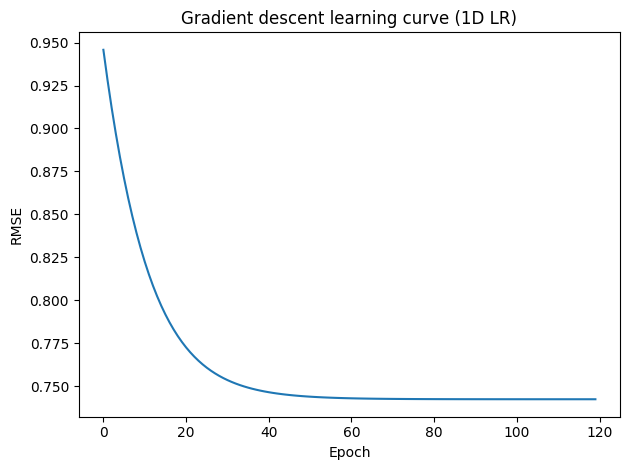

In [7]:
def compute_gradients_1d(X: np.ndarray, y: np.ndarray, w: float, b: float) -> Tuple[float, float]:
    """
    Compute gradients of MSE loss (not RMSE) w.r.t w and b.
    We can use MSE because it's simpler for derivatives; updating under MSE or RMSE is similar near optimum.
    d/dw MSE = (2/n) * sum( (w*X + b - y) * X )
    d/db MSE = (2/n) * sum( (w*X + b - y) )
    """
    n = len(X)
    yhat = w * X + b
    residual = yhat - y
    dw = (2.0 / n) * np.sum(residual * X)
    db = (2.0 / n) * np.sum(residual)
    return float(dw), float(db)


def gradient_descent_1d(X: np.ndarray, y: np.ndarray, w0: float, b0: float,
                        lr: float = 0.0001, epochs: int = 100) -> Tuple[float, float, List[float]]:
    """Run gradient descent and return final (w, b, loss_history)."""
    w, b = float(w0), float(b0)
    losses = []
    for epoch in range(epochs):
        dw, db = compute_gradients_1d(X, y, w, b)
        w -= lr * dw
        b -= lr * db
        loss = rmse(y, w * X + b)
        losses.append(loss)
        if epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch:4d} | RMSE: {loss:.6f} | w: {w:.6f} | b: {b:.6f}")
    return w, b, losses


# Initialize at zeros:
w_init, b_init = 1.0, 1.0
w_hat, b_hat, loss_hist = gradient_descent_1d(X, y, w_init, b_init, lr=0.0001, epochs=120)

# Plot the training curve (single figure).
plt.figure()
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Gradient descent learning curve (1D LR)")
plt.tight_layout()
plt.show()

**Figure: Gradient descent learning curve (1D LR)**  

- Horizontal axis is training epoch; vertical axis is RMSE.
- A downward trend indicates the model is fitting the training data.
- Plateaus suggest the learning rate or capacity may limit further improvement.
- To diagnose generalization, compare with a validation curve when available.
- Beware the learning rate: set too large (try it!) and it will blow up. 
- Usually a good idea to standardise the x (and y) values to avoid these kinds of numerical problems too

## Section 6 — From 1 feature to many: vector & matrix forms

Let's construct a toy feature matrix with 2 inputs (e.g., temperature and humidity yesterday).
We'll create tiny synthetic data to keep focus on the shapes.

In [8]:
n_samples = 5
X2 = np.column_stack([
    X,                                  # feature 1 = temperature yesterday
    np.array([65, 70, 68, 72, 60], float)  # feature 2 = humidity yesterday (%)
])  # shape: (5, 2)

# We'll pretend "today's temperature" depends on both features linearly.
# For demo, set up pseudo-true parameters:
w_true = np.array([1.02, -0.03])   # weights for (temp, humidity)
b_true = 0.06                      # small bias

y2 = X2 @ w_true + b_true  # forward pass in vector form
show_matrix("X2", X2)
show_vector("w_true", w_true)
print(f"b_true: {b_true:.4f}")
show_vector("y2 = X2 @ w_true + b_true", y2)

# EXERCISE: Check shapes. X2 is (5,2); w_true is (2,); bias is scalar. Why does broadcasting work here?

def predict_lr_multi(X: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    """Vectorized forward pass for multi-feature linear regression."""
    return X @ w + b

X2 (shape (5, 2)):
[[16.0900 65.0000]
 [15.5600 70.0000]
 [15.8500 68.0000]
 [15.6900 72.0000]
 [15.0100 60.0000]]
w_true (shape (2,)): [ 1.0200 -0.0300]
b_true: 0.0600
y2 = X2 @ w_true + b_true (shape (5,)): [14.5218 13.8312 14.1870 13.9038 13.5702]


## Section 7 — Binary classification: logistic regression forward steps

In [9]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Logistic sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))


def binary_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-15) -> float:
    """
    Binary cross-entropy loss.
    We clip probabilities for numerical stability to avoid log(0).
    """
    y_prob = np.clip(y_prob, eps, 1.0 - eps)
    return float(-np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)))


# Build a tiny synthetic binary dataset with two features (x1, x2), and a linearly separable boundary.
rng = np.random.default_rng(0)
N = 60
x1 = rng.normal(loc=0.0, scale=1.0, size=N)
x2 = rng.normal(loc=0.0, scale=1.0, size=N)
Xb = np.column_stack([x1, x2])
# True underlying separator: 0.7 * x1 - 0.5 * x2 + 0.2 > 0 ⇒ class 1
ybin = (0.7 * x1 - 0.5 * x2 + 0.2 > 0).astype(float)

# Forward pass with random weights:
w_log = rng.normal(size=2)
b_log = 0.0
z = Xb @ w_log + b_log
p = sigmoid(z)
bce = binary_cross_entropy(ybin, p)
print(f"Random-init logistic regression → BCE = {bce:.4f}")

# NOTE: We aren't training yet — just connecting the forward step to probabilities in (0,1).

Random-init logistic regression → BCE = 0.8821


## Section 8 — Activation functions: sigmoid, tanh, ReLU (by hand)

z_demo (shape (13,)): [-3.0000 -2.5000 -2.0000 -1.5000 -1.0000 -0.5000  0.0000  0.5000  1.0000
  1.5000  2.0000  2.5000  3.0000]
sigmoid(z_demo) (shape (13,)): [0.0474 0.0759 0.1192 0.1824 0.2689 0.3775 0.5000 0.6225 0.7311 0.8176
 0.8808 0.9241 0.9526]
tanh(z_demo) (shape (13,)): [-0.9951 -0.9866 -0.9640 -0.9051 -0.7616 -0.4621  0.0000  0.4621  0.7616
  0.9051  0.9640  0.9866  0.9951]
relu(z_demo) (shape (13,)): [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 1.5000
 2.0000 2.5000 3.0000]


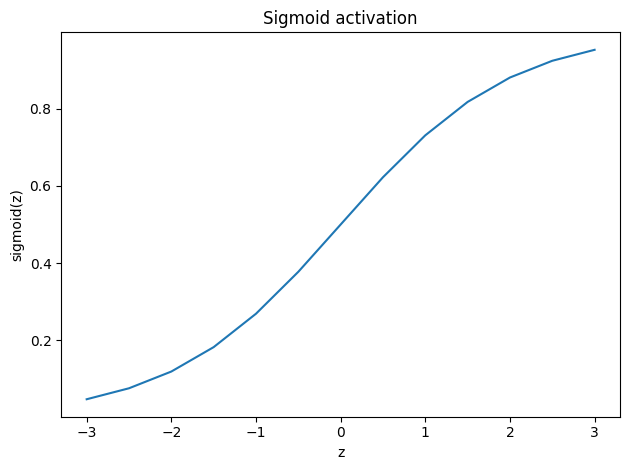

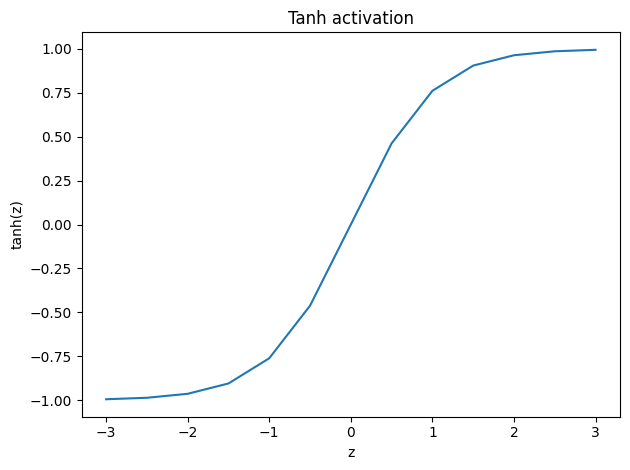

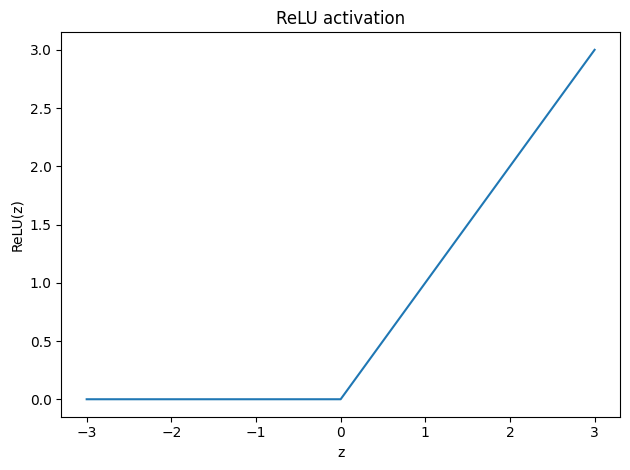

In [10]:
def relu(z: np.ndarray) -> np.ndarray:
    """ReLU activation."""
    return np.maximum(0.0, z)


def tanh(z: np.ndarray) -> np.ndarray:
    """Hyperbolic tangent."""
    return np.tanh(z)


# Demo: apply activations to a simple pre-activation vector
z_demo = np.linspace(-3, 3, 13)
show_vector("z_demo", z_demo)
show_vector("sigmoid(z_demo)", sigmoid(z_demo))
show_vector("tanh(z_demo)", tanh(z_demo))
show_vector("relu(z_demo)", relu(z_demo))

# Plot the three activation curves on separate figures (course rule: one chart per figure).
plt.figure()
plt.plot(z_demo, sigmoid(z_demo))
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.title("Sigmoid activation")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(z_demo, tanh(z_demo))
plt.xlabel("z")
plt.ylabel("tanh(z)")
plt.title("Tanh activation")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(z_demo, relu(z_demo))
plt.xlabel("z")
plt.ylabel("ReLU(z)")
plt.title("ReLU activation")
plt.tight_layout()
plt.show()

## Section 9 — A tiny 2-layer network: manual forward pass

We'll build a 2-2-1 network (2 inputs → 2 hidden (ReLU) → 1 output (linear)).
Shapes:
  W1: (2, 2), b1: (2,)
  W2: (2, 1), b2: (1,)

In [11]:
def forward_2_2_1(x, W1, b1, W2, b2):
    h_pre = x @ W1 + b1
    h = relu(h_pre)
    yhat = h @ W2 + b2        # shape (1,)
    return yhat.item()        # or: return float(yhat.item())     

# Make up a simple example:
x_sample = np.array([0.3, -1.2])
W1 = np.array([[ 0.5, -0.4],
               [ 1.1,  0.2]])
b1 = np.array([0.0, -0.1])
W2 = np.array([[ 0.7],
               [-1.0]])
b2 = np.array([0.05])

yhat_ex = forward_2_2_1(x_sample, W1, b1, W2, b2)
print(f"Manual forward output for x={x_sample}: y_hat = {yhat_ex:.4f}")



Manual forward output for x=[ 0.3 -1.2]: y_hat = 0.0500


- Exercise above: Zero out b1 and b2. Re-run. What's the effect of removing biases?

## Section 10 — Enter PyTorch: tensors, autograd, and fitting LR

[Torch LR] Epoch   0 | RMSE ~ 3.320682 | w: 0.774667 | b: 0.830653
[Torch LR] Epoch  20 | RMSE ~ 1.394039 | w: 0.899109 | b: 0.838558
[Torch LR] Epoch  40 | RMSE ~ 0.856372 | w: 0.944528 | b: 0.841413
[Torch LR] Epoch  60 | RMSE ~ 0.756438 | w: 0.961107 | b: 0.842426
[Torch LR] Epoch  80 | RMSE ~ 0.742110 | w: 0.967159 | b: 0.842765
[Torch LR] Epoch 100 | RMSE ~ 0.740180 | w: 0.969370 | b: 0.842860
[Torch LR] Epoch 120 | RMSE ~ 0.739923 | w: 0.970179 | b: 0.842864
[Torch LR] Epoch 140 | RMSE ~ 0.739887 | w: 0.970476 | b: 0.842836
[Torch LR] Epoch 160 | RMSE ~ 0.739882 | w: 0.970587 | b: 0.842796
[Torch LR] Epoch 180 | RMSE ~ 0.739880 | w: 0.970629 | b: 0.842751


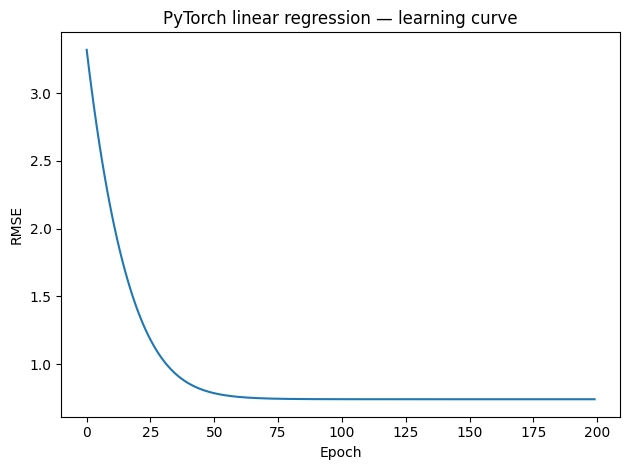

Learned parameters (PyTorch): w ≈ 0.9706, b ≈ 0.8427


In [12]:
# We delay importing torch until now to keep early sections math-first.
import torch
torch.manual_seed(42)

# Convert our original small dataset to torch tensors.
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape (5,1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (5,1)

# Define a minimal linear model: y = w*X + b
model_lr = torch.nn.Linear(in_features=1, out_features=1, bias=True)

# Mean Squared Error loss and a basic optimizer (SGD).
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model_lr.parameters(), lr=0.0001)

# Train loop — VERY small, for demonstration.
epochs = 200
losses_torch = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model_lr(X_t)
    loss = criterion(y_pred, y_t)
    loss.backward()       # autograd computes d(loss)/d(params)
    optimizer.step()      # update parameters
    losses_torch.append(float(torch.sqrt(loss).item()))  # store RMSE
    if epoch % 20 == 0:
        w_val = model_lr.weight.item()
        b_val = model_lr.bias.item()
        print(f"[Torch LR] Epoch {epoch:3d} | RMSE ~ {math.sqrt(loss.item()):.6f} | w: {w_val:.6f} | b: {b_val:.6f}")

# Plot the PyTorch learning curve (single figure).
plt.figure()
plt.plot(np.arange(len(losses_torch)), losses_torch)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("PyTorch linear regression — learning curve")
plt.tight_layout()
plt.show()

# Inspect learned parameters.
w_learned = model_lr.weight.detach().cpu().numpy().squeeze()
b_learned = model_lr.bias.detach().cpu().numpy().squeeze()
print(f"Learned parameters (PyTorch): w ≈ {w_learned:.4f}, b ≈ {b_learned:.4f}")

**Figure: PyTorch linear regression — learning curve**  

- Horizontal axis is training epoch; vertical axis is RMSE.
- A downward trend indicates the model is fitting the training data.
- Plateaus suggest the learning rate or capacity may limit further improvement.
- To diagnose generalization, compare with a validation curve when available.

## Section 11 — PyTorch: a tiny MLP for binary classification

[MLP] Epoch   0 | loss: 0.7201 | acc: 0.583
[MLP] Epoch  50 | loss: 0.0954 | acc: 0.983
[MLP] Epoch 100 | loss: 0.0430 | acc: 0.983
[MLP] Epoch 150 | loss: 0.0299 | acc: 1.000
[MLP] Epoch 200 | loss: 0.0232 | acc: 1.000
[MLP] Epoch 250 | loss: 0.0187 | acc: 1.000


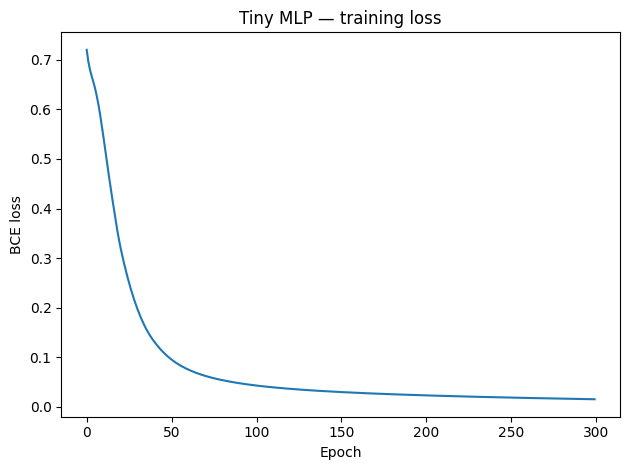

In [13]:
# We'll reuse Xb (N x 2) and ybin (N) from Section 7 but convert to tensors.
Xb_t = torch.tensor(Xb, dtype=torch.float32)
ybin_t = torch.tensor(ybin, dtype=torch.float32).unsqueeze(1)

class TinyMLP(torch.nn.Module):
    """
    A tiny multilayer perceptron:
        input 2 → hidden 3 (ReLU) → output 1 (logit)
    We'll use BCEWithLogitsLoss which expects raw scores ("logits"),
    and combines sigmoid + BCE in a stable way.
    """
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 3)
        self.fc2 = torch.nn.Linear(3, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        logit = self.fc2(h)
        return logit

mlp = TinyMLP()
criterion_bce = torch.nn.BCEWithLogitsLoss()
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.05)

epochs = 300
loss_hist_mlp = []
for epoch in range(epochs):
    optimizer_mlp.zero_grad()
    logits = mlp(Xb_t)
    loss = criterion_bce(logits, ybin_t)
    loss.backward()
    optimizer_mlp.step()
    loss_hist_mlp.append(float(loss.item()))
    if epoch % 50 == 0:
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            acc = (preds.eq(ybin_t).float().mean().item())
        print(f"[MLP] Epoch {epoch:3d} | loss: {loss.item():.4f} | acc: {acc:.3f}")

# Plot training loss (single figure).
plt.figure()
plt.plot(np.arange(len(loss_hist_mlp)), loss_hist_mlp)
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.title("Tiny MLP — training loss")
plt.tight_layout()
plt.show()

**Figure: Tiny MLP — training loss**  

- Horizontal axis is training epoch; vertical axis is BCE loss.
- A downward trend indicates the model is fitting the training data.
- Plateaus suggest the learning rate or capacity may limit further improvement.
- To diagnose generalization, compare with a validation curve when available.

## Section 12 — Sanity checks & common pitfalls (from the slides)


1. Check shapes at every layer (especially batch dimension).
2. Do not forget the bias terms.
3. Use appropriate activation for the task (e.g., none/linear for regression, sigmoid/logits for binary).
4. Normalize or standardize inputs when features are on very different scales.
5. Monitor a validation split if data volume allows; early stopping helps.
6. Learning rate matters. Too big → diverge; too small → crawl.
TinyMLP trainable parameters: 13

## Section 13 — Mini-lab ideas (optional explorations)

1. Swap ReLU for tanh in the hidden layer. What changes?
2. Standardize x1,x2 before feeding the MLP; rerun and compare convergence.
3. Back in Section 5, try different learning rates (1e-3 to 1e-1) and plot learning curves.

All done 🎉  You have stepped from dot products → linear models → activations → tiny NNs,
and you've seen both from-scratch math and PyTorch's autograd in action.